In [3]:
from training import *
from analysis import *
from network import *

## accurarcy results on MNIST dataset

15
$D_{hidden} =20$, 1 parallel synapse acc mean +/- std: 95.36 \pm 0.08 \%
15
$D_{hidden} =20$, 2 parallel synapses acc mean +/- std: 95.83 \pm 0.06 \%
15
$D_{hidden} =20$, 3 parallel synapses acc mean +/- std: 96.01 \pm 0.06 \%
15
$D_{hidden} =20$, 5 parallel synapses acc mean +/- std: 96.27 \pm 0.06 \%
15
$D_{hidden} =20$, 10 parallel synapses acc mean +/- std: 96.33 \pm 0.05 \%
15
$D_{hidden} =22$, linear synapse acc mean +/- std: 94.77 \pm 0.17\% 


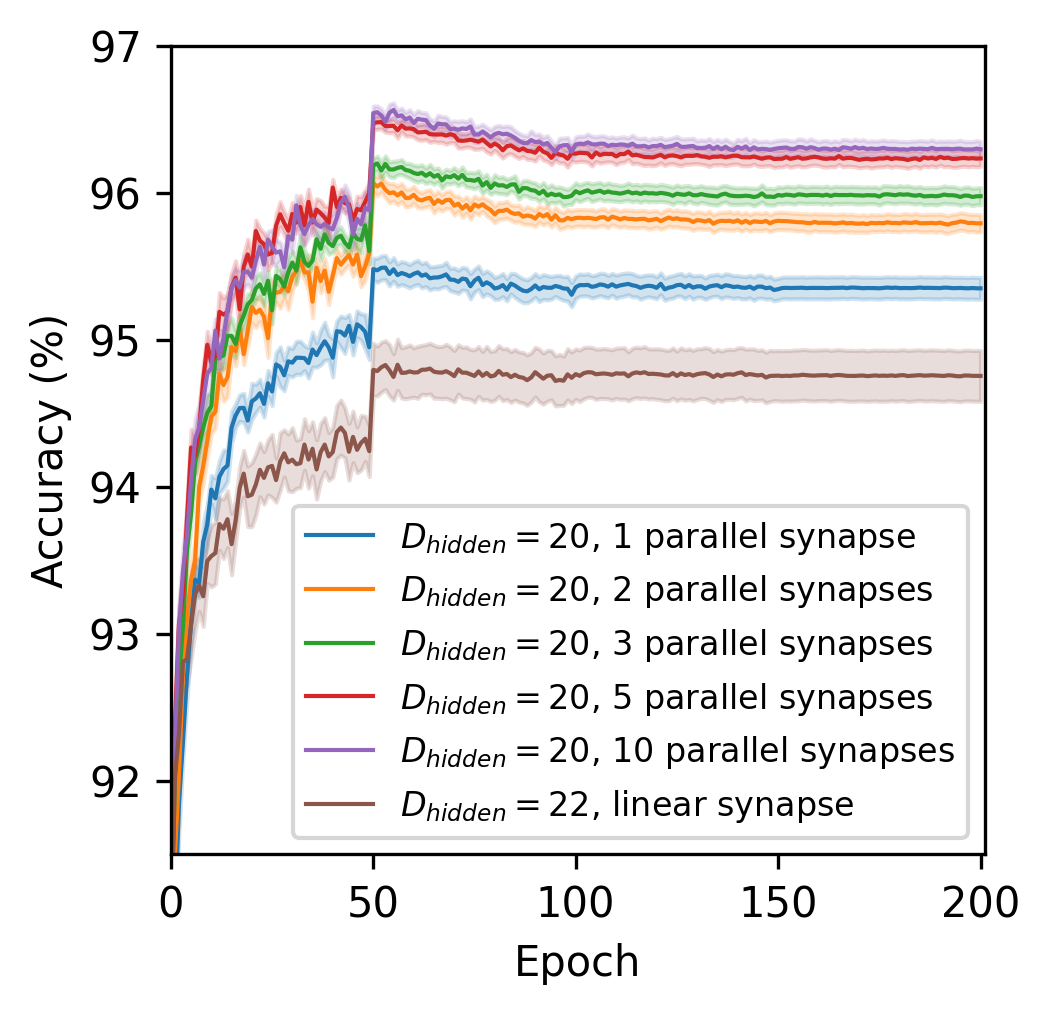

In [4]:

plt.figure(figsize=(3.5, 3.5),dpi=300)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink','tab:gray']
H = 20

for i,M in enumerate([1,2,3,5,10]):
        file_name = f'./results_MNIST/parallel_nll_H{H}_M{M}_bias10_range50_lr_thres0.05_lr_ampli0.001_lr_slope0.001_schedulerTrue_decrease_50_epoch_factor_0.1_initialization_v3.pkl'
        with open(file_name, 'rb') as f:
                results1 = pickle.load(f)[:15]
        if M == 1:
                label = r'$D_{hidden} =20$,'+f' {M} parallel synapse'
        else:
                label = r'$D_{hidden} =20$,'+f' {M} parallel synapses' 
                                                

        print(len(results1))
        acc1 = get_acc(results1) 
        plt.plot(acc1.mean(axis=0), label= label, linestyle='-', linewidth = 1,color=colors[i])
        plt.fill_between(np.arange(acc1.shape[1]), 
                acc1.mean(axis = 0) - acc1.std(axis = 0)/np.sqrt(len(results1)), 
                acc1.mean(axis = 0) + acc1.std(axis = 0)/np.sqrt(len(results1)), alpha = 0.2, color=colors[i])
        
        print(label + ' acc mean +/- std: {:.2f} \pm {:.2f} \%'.format(acc1.mean(axis=0)[100], acc1.std(axis = 0)[100]/np.sqrt(len(results1))) )


for i,H in enumerate([ 22]):
        file_name = f'./results_MNIST/2nn_nll_H{H}_schedulerTrue_decrease_50_epoch_factor_0.1.pkl'
        with open(file_name, 'rb') as f:
                results1 = pickle.load(f)[:15]
        label = r'$D_{hidden} =22$,'+f' linear synapse' 
        
        print(len(results1))
        acc1 = get_acc(results1)
        # plt.subplot(1,2,1)
        plt.plot(acc1.mean(axis=0), label= label, linestyle='-', linewidth = 1,color=colors[i+5])
        plt.fill_between(np.arange(acc1.shape[1]), 
                acc1.mean(axis = 0) - acc1.std(axis = 0)/np.sqrt(len(results1)), 
                acc1.mean(axis = 0) + acc1.std(axis = 0)/np.sqrt(len(results1)), alpha = 0.2, color=colors[i+5])
        print(label + ' acc mean +/- std: {:.2f} \pm {:.2f}\% '.format(acc1.mean(axis=0)[100], acc1.std(axis = 0)[100]/np.sqrt(len(results1))) )

H = 20 
plt.legend( loc='lower right', fontsize = 8, bbox_to_anchor=(1., 0))


plt.ylim([91.5, 97.])
plt.xlim([0, acc1.shape[1]])
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.savefig('./results_MNIST/parallel_synapse_H_{H}.pdf', bbox_inches='tight')

## parallel synapse, model statistics:

loading  ./results_MNIST/parallel_nll_H20_M3_bias10_range50_lr_thres0.05_lr_ampli0.001_lr_slope0.001_schedulerTrue_decrease_50_epoch_factor_0.1_initialization_v3.pkl


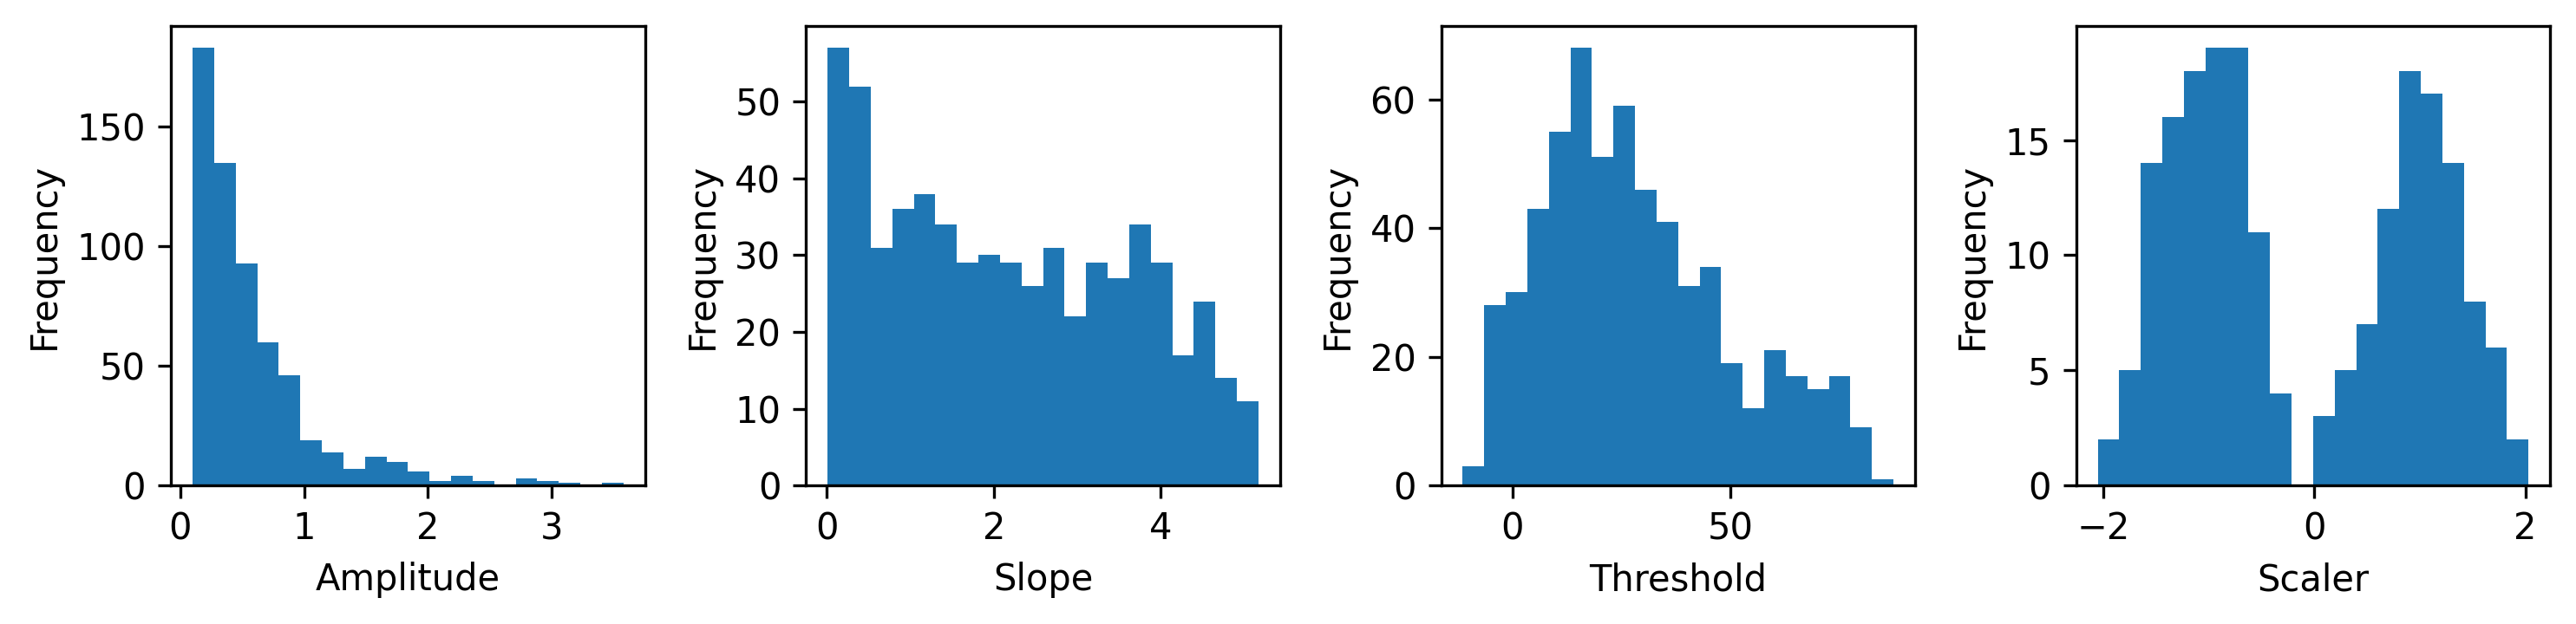

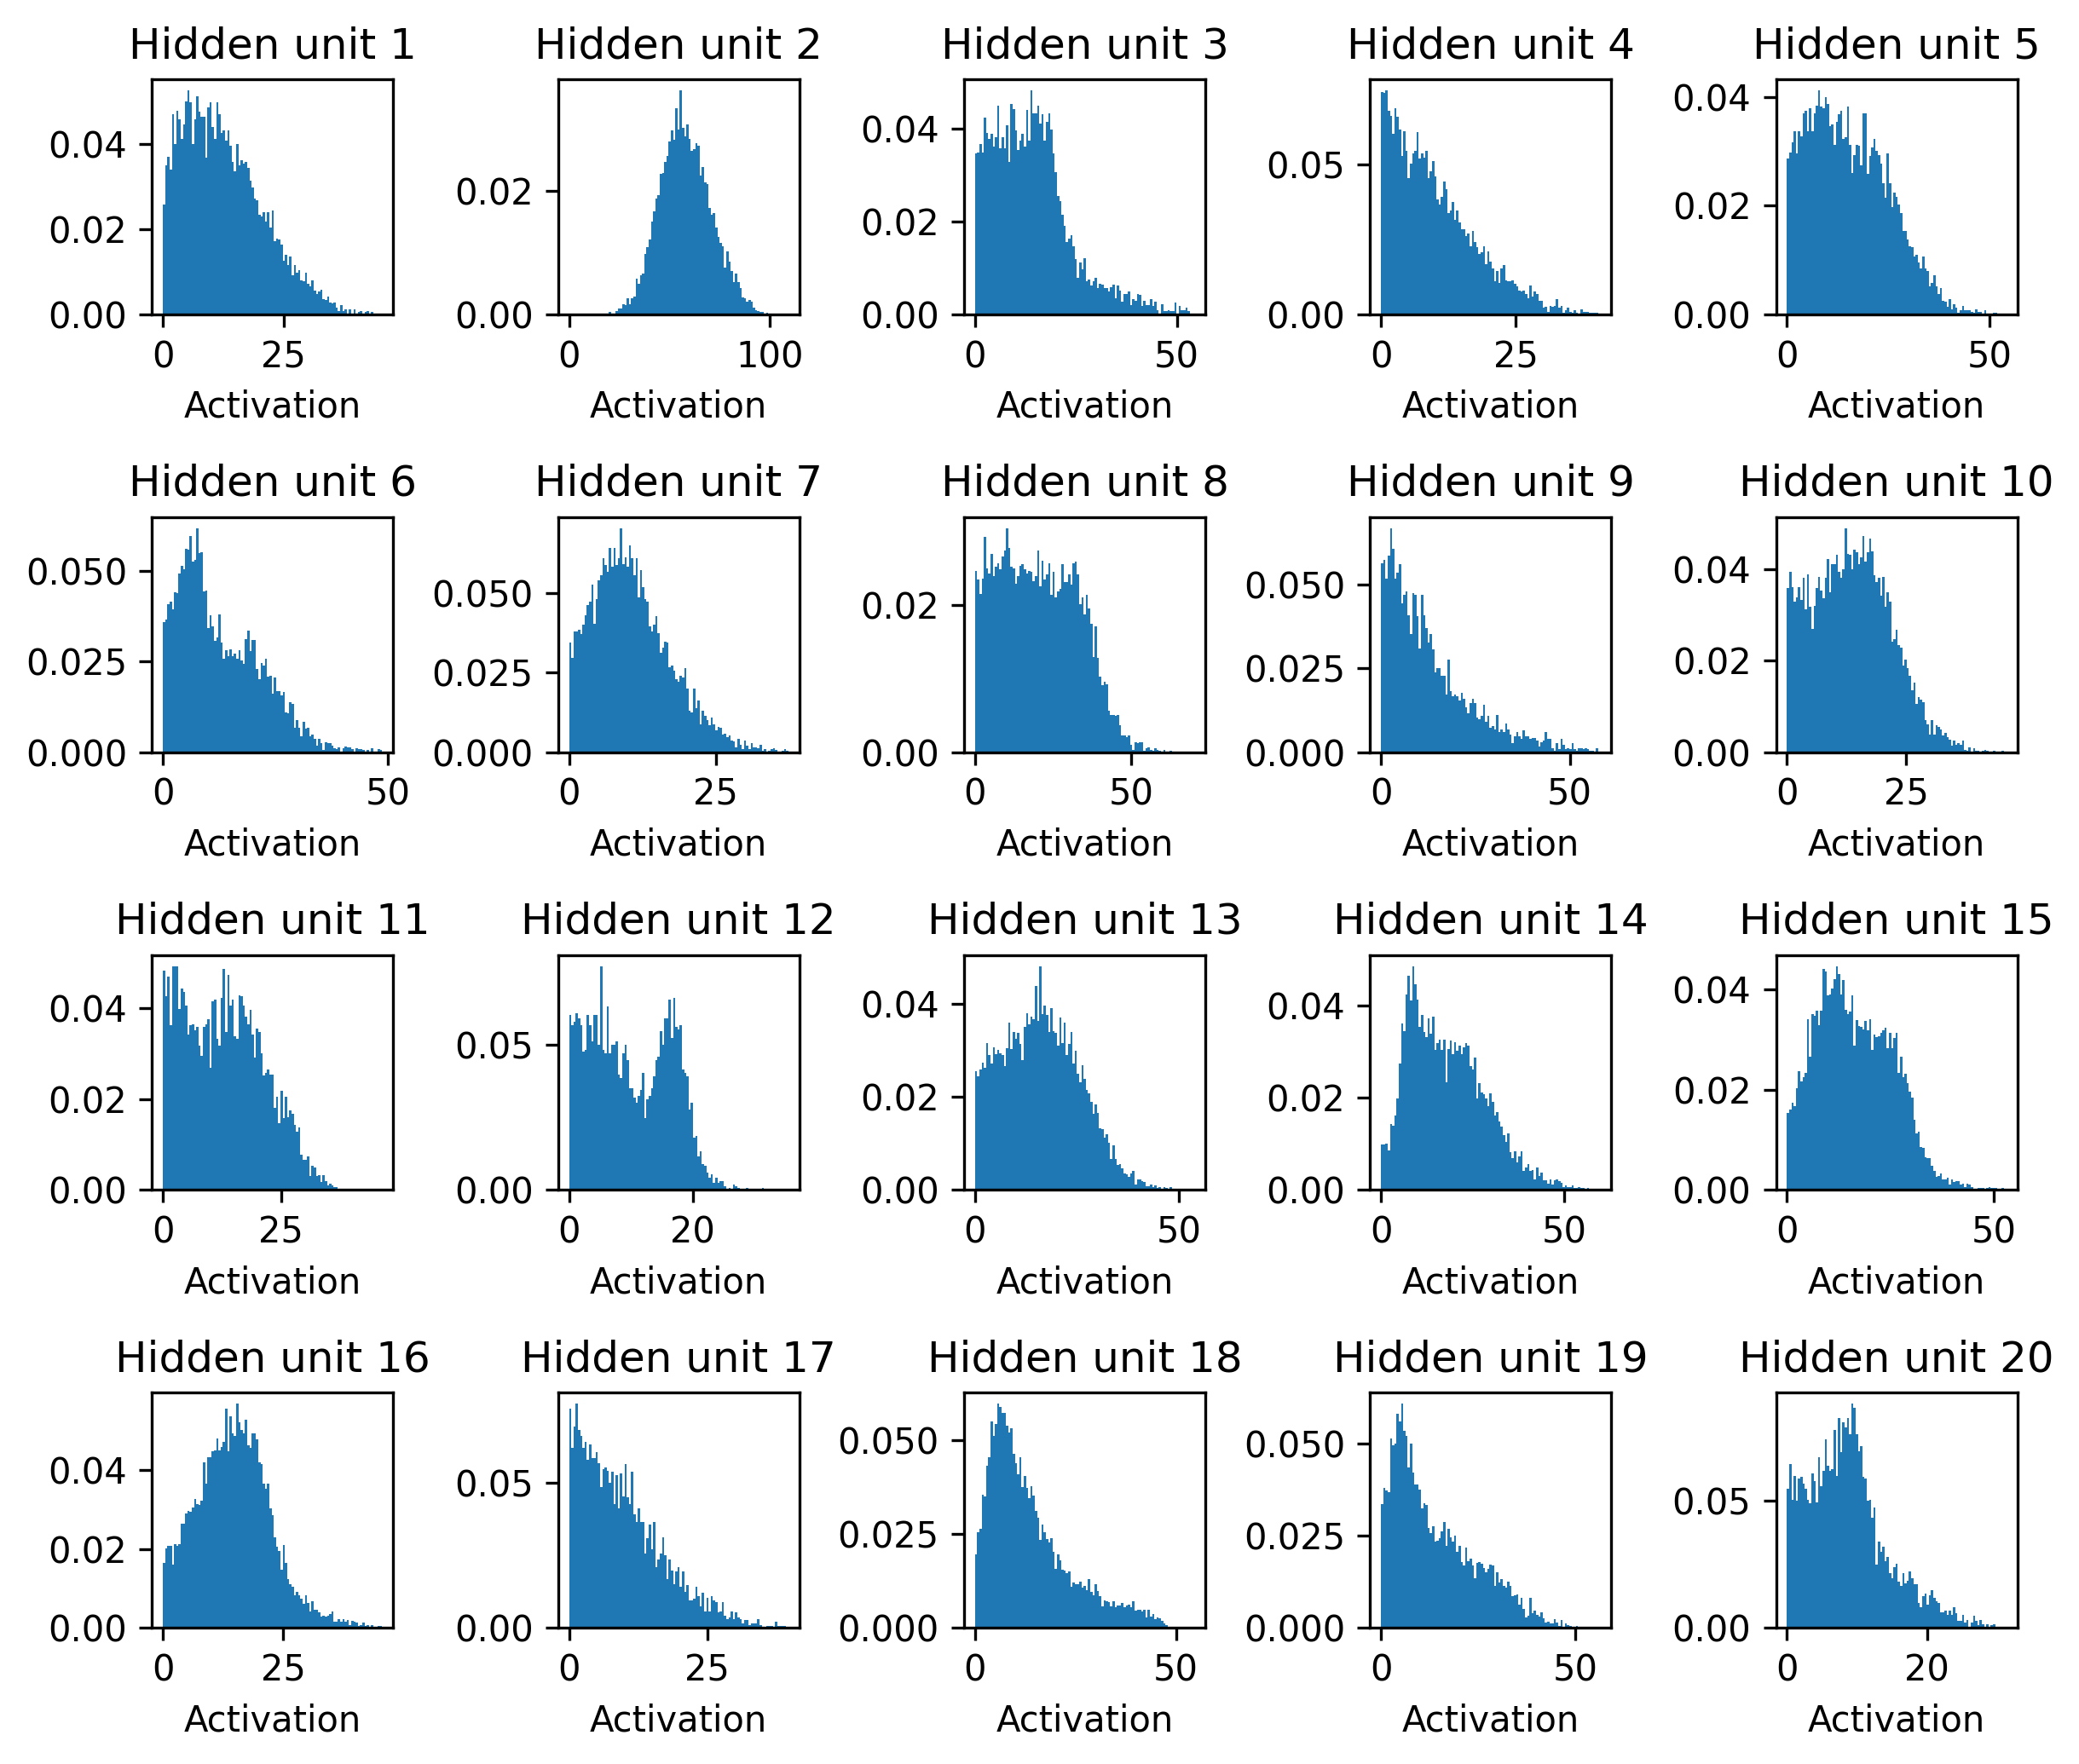

transmission function, scaler = True, sign = True


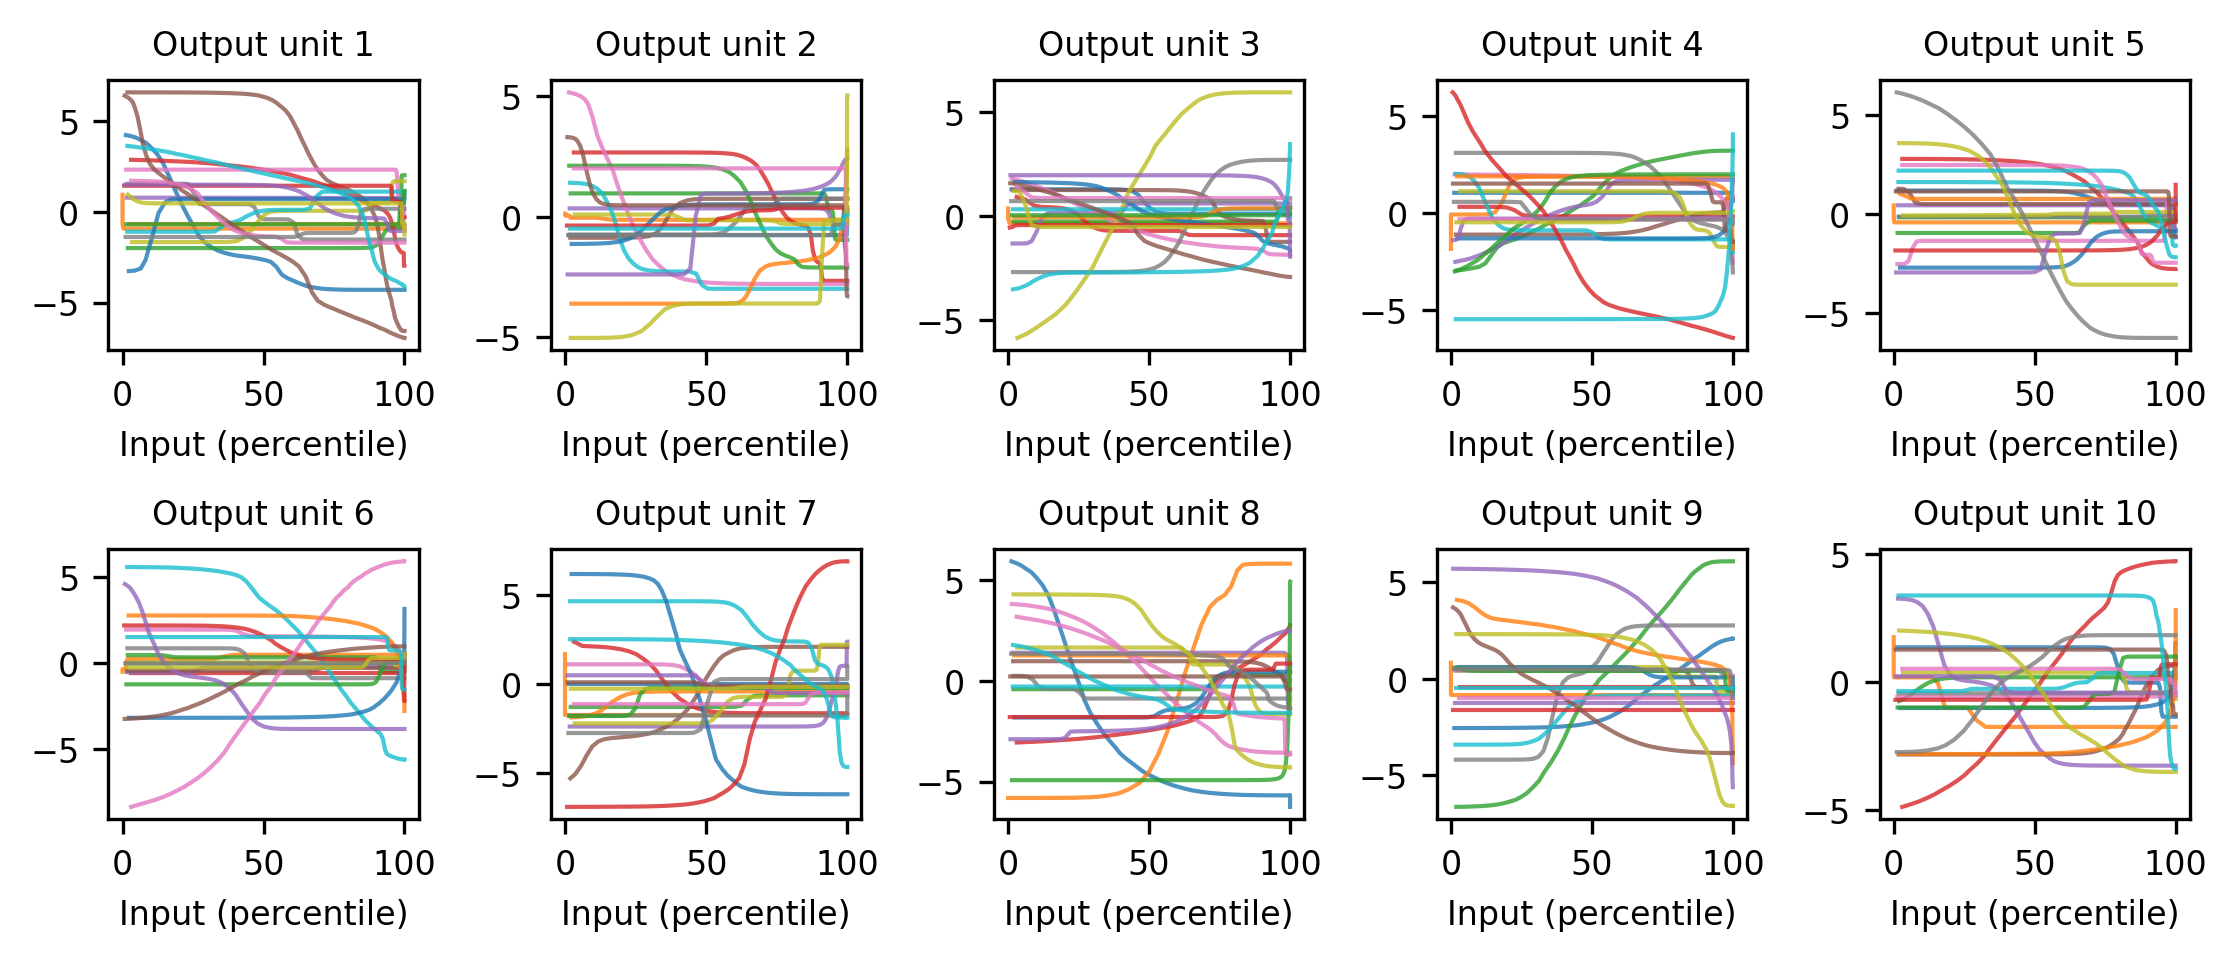

transmission function, scaler = True, sign = False


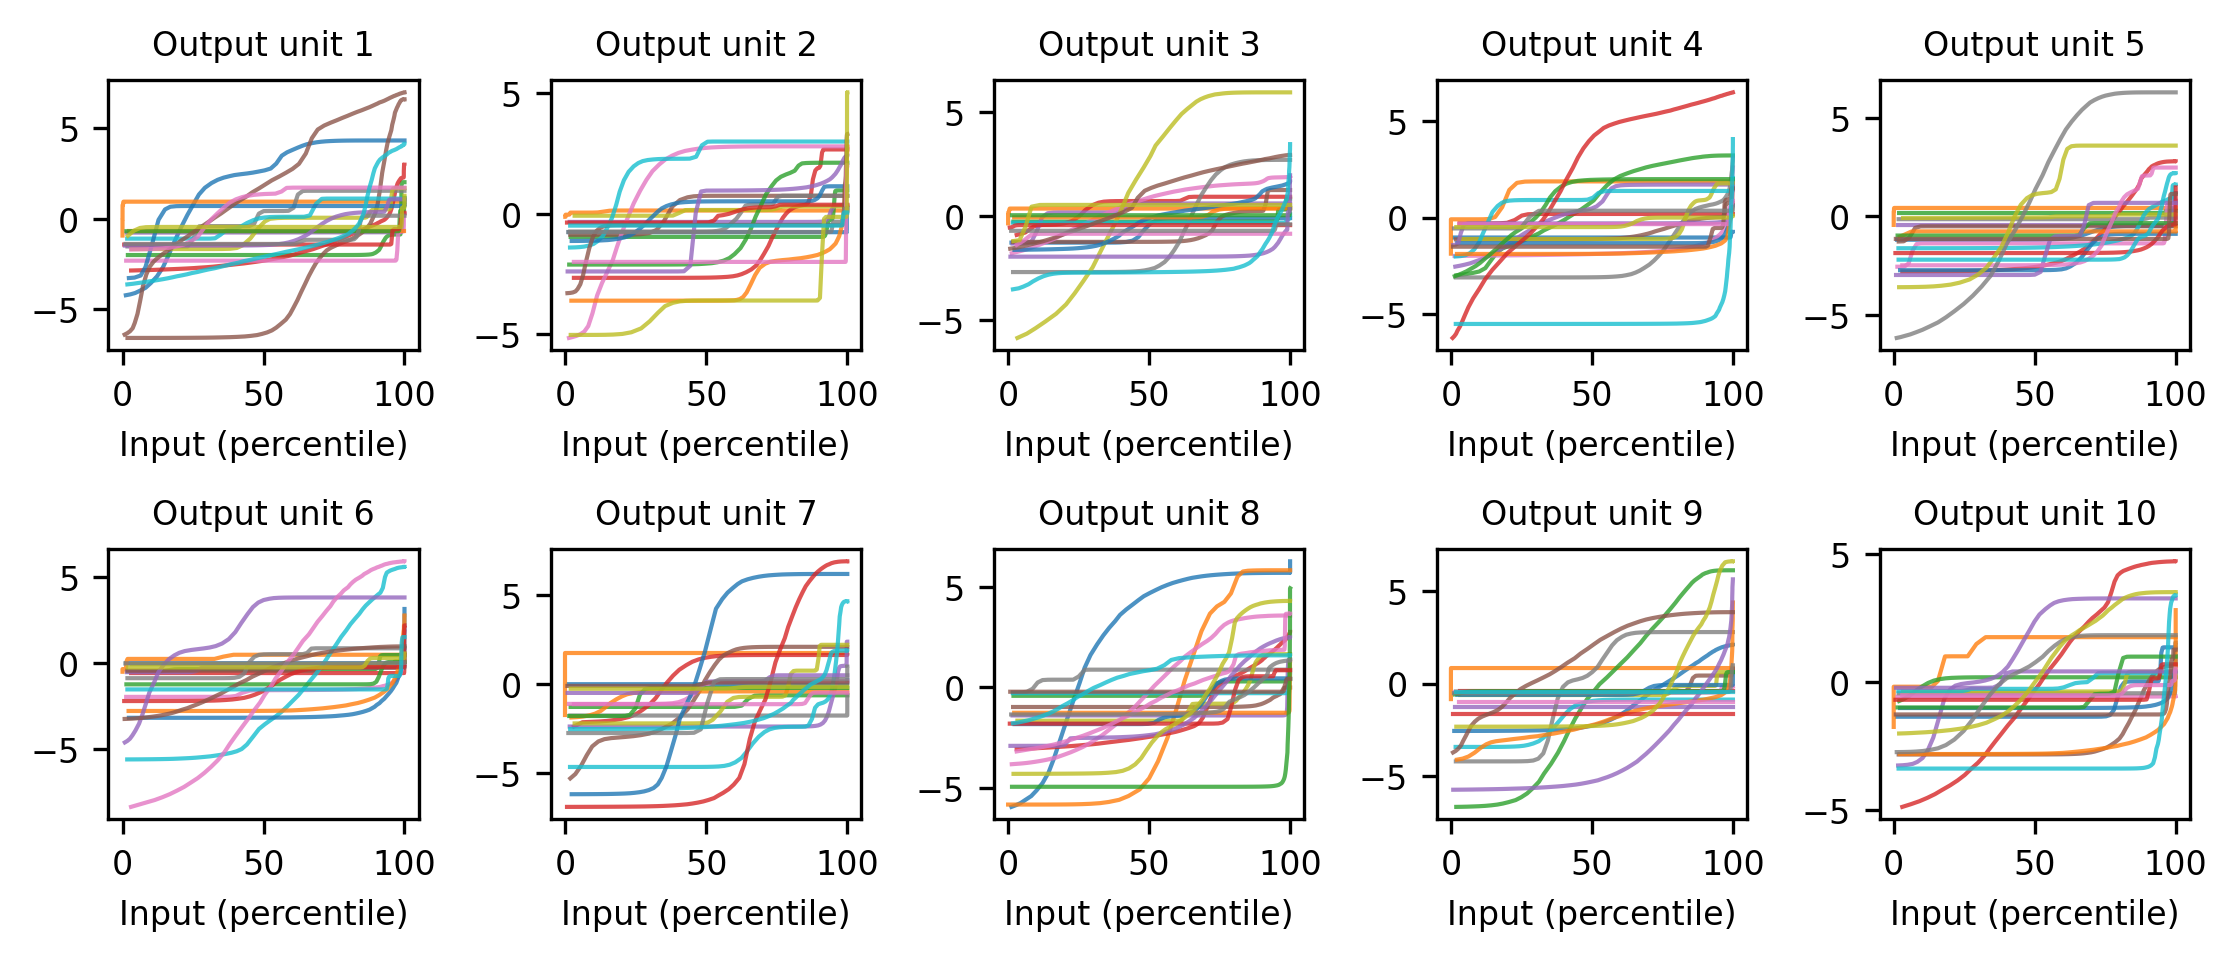

transmission function, scaler = False, sign = False


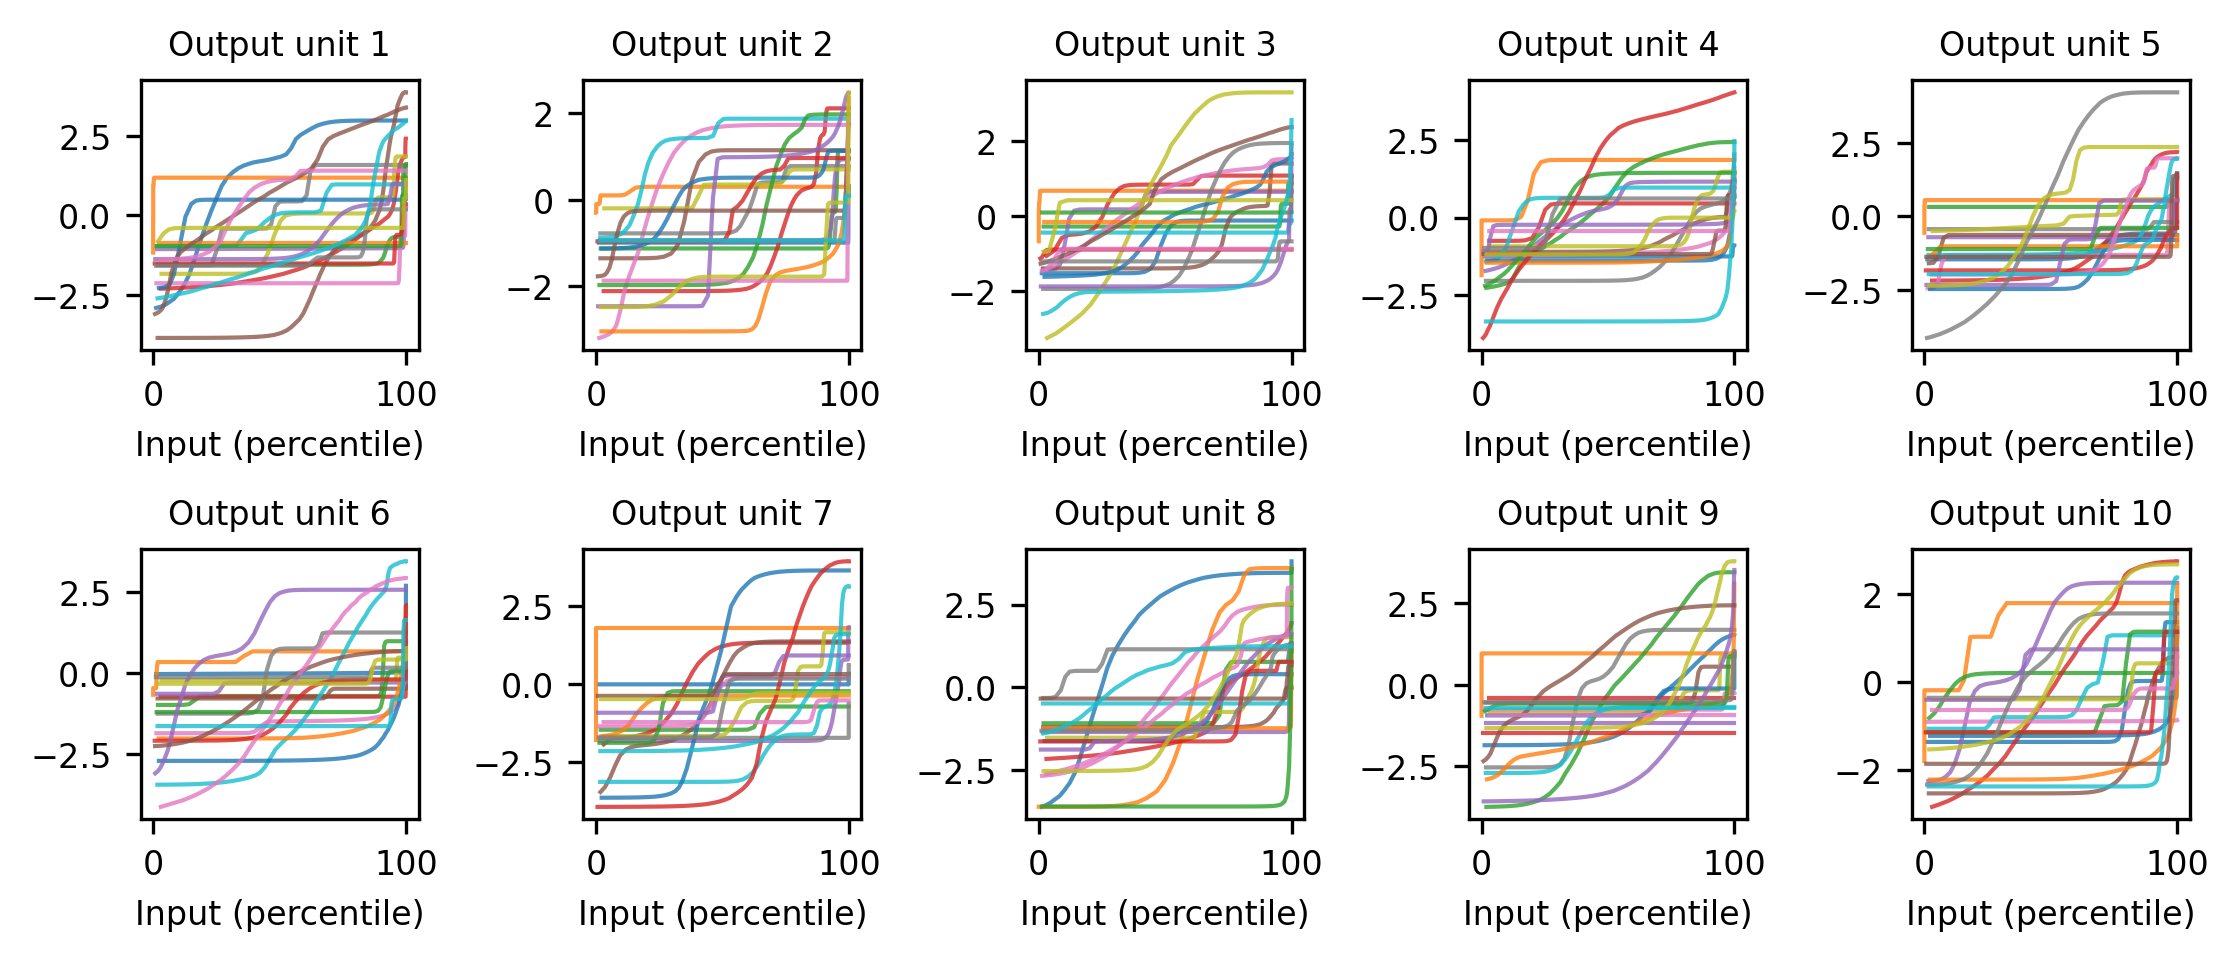

In [5]:
H=20
for M in [3]:

    for bias in [10]:
        loss_type = 'nll'
        file_name = './results_MNIST/parallel_'+loss_type+f'_H{H}_M{M}_bias10_range50_lr_thres0.05_lr_ampli0.001_lr_slope0.001_schedulerTrue_decrease_50_epoch_factor_0.1_initialization_v3.pkl'
        print('loading ', file_name)
        with open(file_name, 'rb') as f:
            results = pickle.load(f)

        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
        trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

        testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
        testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)
        for i,result in enumerate(results[2:3]):
            model = result['model']
            
            plot_parallel_synapse_params(model)

            
            hidden = plot_input_histogram_to_parallel_synapse_layer(model, testloader, hidden_act='relu', 
                        file_name = f'./results_MNIST/parallel_synapse_H_{H}_M_{M}_trial_{i+1}_signed_scaled.pdf', is_sign=True) 
            hidden = plot_input_histogram_to_parallel_synapse_layer(model, testloader, hidden_act='relu',
                        file_name = f'./results_MNIST/parallel_synapse_H_{H}_M_{M}_trial_{i+1}_unsigned_scaled.pdf', is_sign=False)
            hidden = plot_input_histogram_to_parallel_synapse_layer(model, testloader, hidden_act='relu',
                        file_name = f'./results_MNIST/parallel_synapse_H_{H}_M_{M}_trial_{i+1}_unsigned_unscaled.pdf', is_sign=False, is_scaler=False)


In [7]:
'''
plot 2nn model training results and hidden activation
'''
# results = pickle.load(open('./results_MNIST/2nn_nll_H22_schedulerTrue_decrease_50_epoch_factor_0.1.pkl', 'rb'))
# for result in results[:1]:
#     model = result['model']
#     hidden, final = get_hidden_final_activation_2NN(model, testloader)
#     plot_hidden_final_loss_2NN(model, hidden, final, result)
#     plt.show()